# Customer Segmentation

In [1]:
# import required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score , calinski_harabasz_score , davies_bouldin_score
from sklearn.decomposition import PCA

In [3]:
# load and prepare dataset

In [4]:
dataset = pd.read_csv("Mall_Customers.csv")

In [5]:
dataset.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
dataset.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

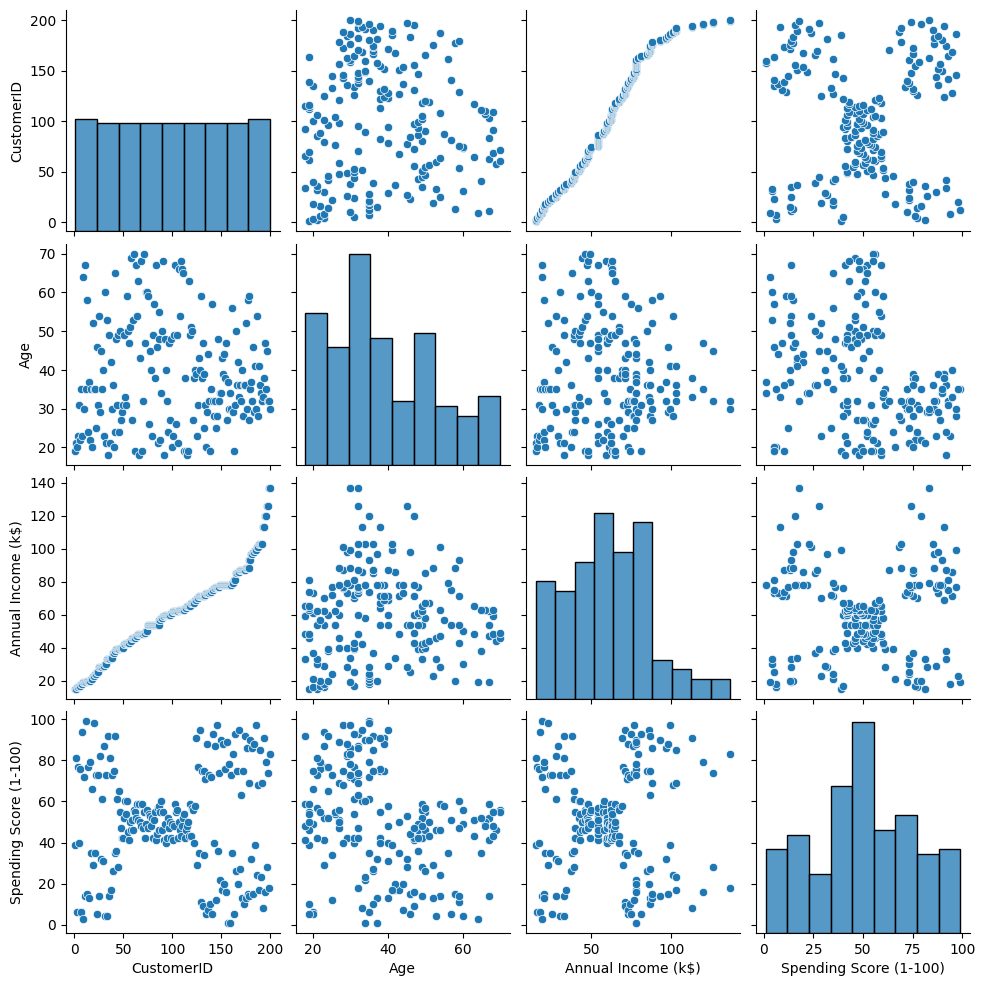

In [8]:
sns.pairplot(data=dataset)
plt.show()

In [9]:
x = dataset.iloc[:,[2,3,4]]

In [10]:
# Scaling

In [11]:
scalar = StandardScaler()
x_scaled = scalar.fit_transform(x)

In [12]:
# Find best cluster using elbow method and silhoute score using loop

In [13]:
wcss = []
for i in range(2,21):
    kmn = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmn.fit(x_scaled)
    wcss.append(kmn.inertia_)

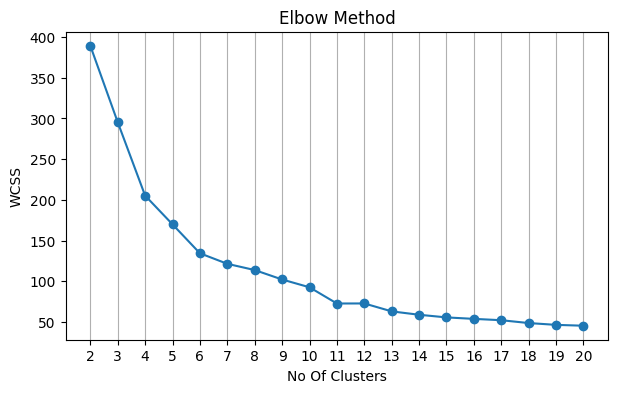

In [14]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(2,21)],wcss,marker="o")
plt.xlabel("No Of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.xticks([i for i in range(2,21)])
plt.grid(axis="x")
plt.show()

In [15]:
# silhoute score

In [16]:
sil_score = []
for j in range(2,21):
    km = KMeans(n_clusters=j,init='k-means++')
    km.fit(x_scaled)
    sil_score.append(silhouette_score(x,labels=km.labels_))

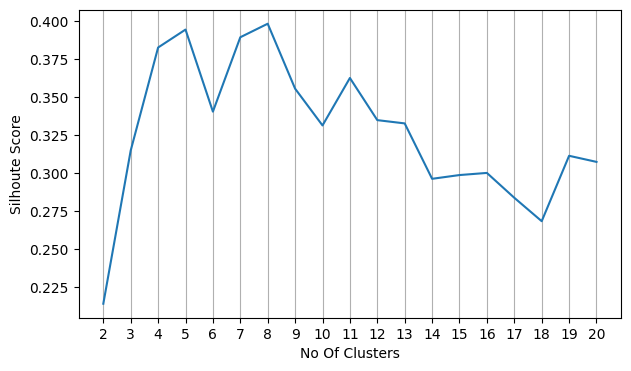

In [17]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(2,21)],sil_score)
plt.xlabel("No Of Clusters")
plt.ylabel("Silhoute Score")
plt.xticks([i for i in range(2,21)])
plt.grid(axis="x")
plt.show()

In [18]:
kmeans = KMeans(n_clusters=6,init='k-means++')
labels = kmeans.fit_predict(x_scaled)
dataset["Cluster"] = labels
centroids = kmeans.cluster_centers_

In [19]:
# Evaluate Clusters

In [20]:
eval_metrics = {

    "Silhouette Score" : silhouette_score(x,labels)*100,
    "Calinski-Harabasz Score" : calinski_harabasz_score(x,labels),
    "Davies-Bouldin Score" : davies_bouldin_score(x,labels)
}

In [21]:
print("===  Cluster Evaluation Metrics ===")
for k,v in eval_metrics.items():
    print(f"{k}: {v:.3f}")

===  Cluster Evaluation Metrics ===
Silhouette Score: 44.802
Calinski-Harabasz Score: 164.096
Davies-Bouldin Score: 0.752


In [22]:
# Visualize Clusters (2D PCA)

In [23]:
print(centroids)

[[-0.44191719  0.99158305  1.23950275]
 [-0.85043527 -0.14894113 -0.04147777]
 [ 0.17329545  1.06645385 -1.2980103 ]
 [ 1.25472096 -0.24021294 -0.04399777]
 [-0.99396865 -1.34734766  1.06404834]
 [ 0.47895722 -1.30822992 -1.19644353]]


Text(0.5, 1.0, 'Customer Segments (PCA Projection)')

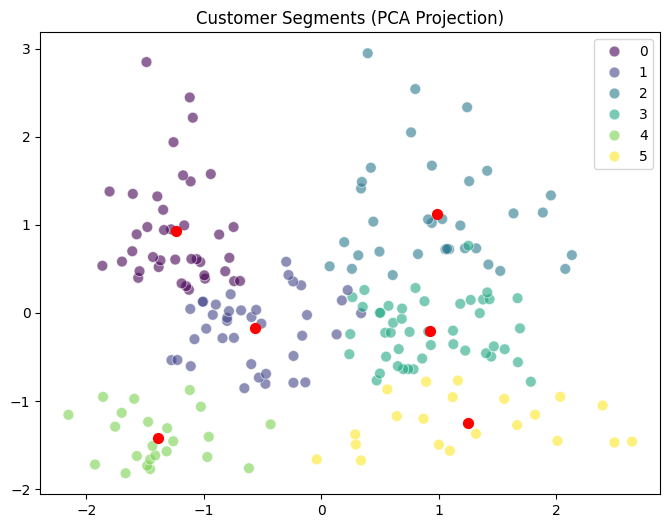

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_scaled)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='viridis', s=60, alpha=0.6)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=50, marker='o')
plt.title("Customer Segments (PCA Projection)")

In [25]:
# Label Clusters with Descriptive Names

In [26]:
cluster_profile = dataset.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

def label_segment(row):
    if row['Annual Income (k$)'] > 60 and row['Spending Score (1-100)'] > 60:
        return 'High-Value'
    elif row['Annual Income (k$)'] <= 60 and row['Spending Score (1-100)'] > 60:
        return 'Young-Spender'
    elif row['Annual Income (k$)'] > 60 and row['Spending Score (1-100)'] <= 60:
        return 'Careful-Spender'
    else:
        return 'Low-Value'

cluster_labels = cluster_profile.apply(label_segment, axis=1)
dataset['Segment'] = dataset['Cluster'].map(cluster_labels)

In [27]:
# Visualize Clusters (2D PCA)

Text(0.5, 1.0, 'Customer Segments with Descriptive Labels')

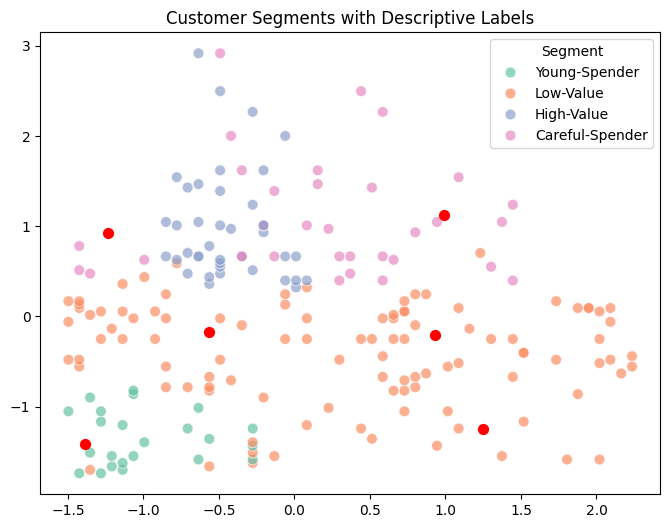

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=x_scaled[:,0], y=x_scaled[:,1], 
    hue=dataset['Segment'], 
    palette='Set2', s=60, alpha=0.7
)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=50, marker='o')
plt.title("Customer Segments with Descriptive Labels")

In [29]:
# Generate Business Report

In [30]:
report = dataset.groupby('Segment').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Customer Count'}).round(1)

print("\n=== Customer Segment Report ===")
print(report)


=== Customer Segment Report ===
                  Age  Annual Income (k$)  Spending Score (1-100)  \
Segment                                                             
Careful-Spender  41.3                88.5                    16.8   
High-Value       32.7                86.5                    82.1   
Low-Value        43.4                49.5                    43.1   
Young-Spender    25.0                25.3                    77.6   

                 Customer Count  
Segment                          
Careful-Spender              34  
High-Value                   39  
Low-Value                   104  
Young-Spender                23  


In [31]:
# Pie Chart of Segment Distribution

Text(0.5, 1.0, 'Customer Segment Distribution')

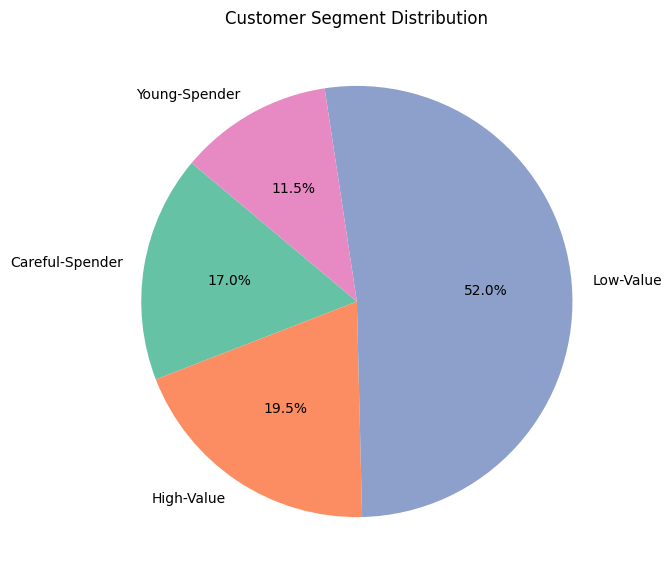

In [32]:
plt.figure(figsize=(7,7))
plt.pie(
    report['Customer Count'], 
    labels=report.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
    # colors=['red','yellow','blue','green']
)
plt.title("Customer Segment Distribution")

In [33]:
dataset['Segment'].unique()

array(['Young-Spender', 'Low-Value', 'High-Value', 'Careful-Spender'],
      dtype=object)